In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader

from binarypredictor import split_functions
from binarypredictor.dataset import FunctionPairDataset
from binarypredictor.net import DerivativeNet, TangentNet

In [2]:
out_features = 500
in_features = out_features

In [296]:
net_0 = DerivativeNet(train=False, net='FirstDerivativeNet_250_s.pth')
net_1 = DerivativeNet(train=False, net='SecondDerivativeNet_250_s.pth')

In [4]:
fpd = FunctionPairDataset(n_functions=1000, filename="test_.csv", overwrite=True, step=1/in_features)
fpd.create_functions()

In [331]:
loader = DataLoader(fpd, batch_size=256)
net = TangentNet(train=True, in_features=in_features * 2, out_features=out_features, hidden_size_linear=500, hidden_layers=2)

In [332]:
x = torch.arange(1e-10, 1., step=fpd.step)

In [333]:
lr = 1e-3

# Workers
loss_func = nn.MSELoss()
optimizer = Adam(net.parameters(), lr=lr)

best_loss = 1000
best_net = net

for i in range(2500):
    for d in loader:
        inp = torch.hstack((d[0][:, :, 0], d[0][:, :, 1]))
        out = net(inp)
        out = torch.clamp(out, min=1e-10, max=1.-1e-4)
        
        f_ = fpd.base_function(**d[1][0], x=out)/d[2].unsqueeze(-1)
        f_der = fpd.first_derivative(**d[1][0], x=out)/d[2].unsqueeze(-1)
        g_der = fpd.first_derivative(**d[1][1])/d[2].unsqueeze(-1)
        
        g_der = torch.clamp(g_der, min=-100, max=100)

        optimizer.zero_grad()
        loss = loss_func(f_der, g_der)
                
        if loss.isinf():
            print('max: ', torch.max(out))
            print('inf')
            break
        
        if loss.isnan():
            print('nan')
            break
        elif loss < 0.2:
            break
            
        loss.backward()
        optimizer.step()
        
    if not loss.isnan() and loss < best_loss:
            best_net = net
            best_loss = loss  
    elif loss.isnan() or loss.isinf():
        break

    if i % 10 == 0:
        print(loss)

tensor(3.7802, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.5062, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(1.1148, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.9988, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.9379, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.8949, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.8336, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.8012, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.7862, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.8020, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.7924, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.7449, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.7652, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.7419, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.7384, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.7324, dtype=torch.float64, grad

tensor(0.5961, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.6090, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5921, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5881, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5857, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5810, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5913, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.6012, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5956, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5896, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5823, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5869, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.6099, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5878, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5977, dtype=torch.float64, grad_fn=<MseLossBackward0>)
tensor(0.5989, dtype=torch.float64, grad

KeyboardInterrupt: 

In [135]:
#torch.save(best_net, 'TangentNet_500_.pth')

In [7]:
#net = torch.load('TangentNet_500_.pth')
#net = best_net

In [358]:
d = fpd[5]
print(d[1])
scale = d[2].unsqueeze(-1)
inp = torch.hstack((d[0][:, 0], d[0][:, 1]))

[{'o': 0, 'T': 2450.135820629669, 'tm1': 1959.6082588586387, 'tm2': 2510.355952147487, 'tm': 2234.982105503063, 'a': 55744.9236754574, 's1': 4.397787376858352, 's2': 8.250182808573065}, {'o': 0, 'T': 2450.135820629669, 'tm1': 1959.6082588586387, 'tm2': 2510.355952147487, 'tm': 2234.982105503063, 'a': 18581.641225152467, 's1': 0, 's2': 0}]


In [369]:
new_idx = torch.arange(1, len(d[0][:, 0]), 2)
inp_ = d[0][new_idx].unsqueeze(0)
splits = split_functions(net_0, net_1, inp_)

torch.Size([1, 250, 2])


IndexError: index 1 is out of bounds for dimension 0 with size 1

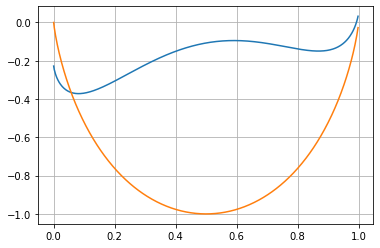

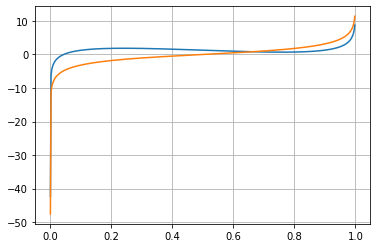

In [359]:
f = fpd.base_function(**d[1][0])/scale
g = fpd.base_function(**d[1][1])/scale
plt.plot(x, f)
plt.plot(x, g)
plt.grid()
plt.show()

f_d = fpd.first_derivative(**d[1][0])/scale
g_d = fpd.first_derivative(**d[1][1])/scale
plt.plot(x, f_d)
plt.plot(x, g_d)
plt.grid()
plt.show()

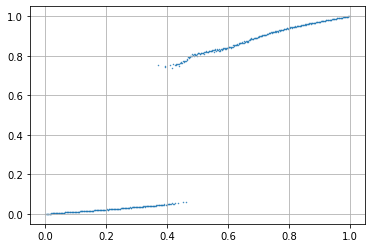

In [360]:
out = net(inp)

plt.scatter(x, out.detach(), s=0.2)
plt.grid()
plt.show()

127


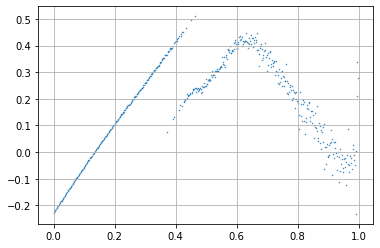

In [361]:
eq = lambda x_, k: (fpd.base_function(**k, x=x_) - x_ * fpd.first_derivative(**k, x=x_))/scale

eqn = (eq(out, d[1][0]) - eq(x, d[1][1]))

i_w_eqn = torch.where(abs(eqn) < 0.1)[0]
print(len(i_w_eqn))
plt.scatter(x, eqn.detach(), s=0.2)
plt.grid()
plt.show()

5


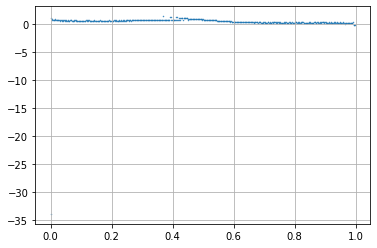

100


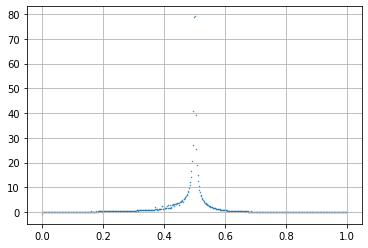

In [362]:
dd = lambda x1, x2: (fpd.first_derivative(**d[1][0],x=x1) - fpd.first_derivative(**d[1][1],x=x2))/scale

diff_der = dd(out, x)
i_w_der = torch.where(abs(diff_der) < 0.1)[0]

print(len(i_w_der))

plt.scatter(x, diff_der.detach(), s=.2)
plt.grid()
plt.show()

diff_der = dd(out, x)/(abs(fpd.first_derivative(**d[1][1], x=x)/scale))
i_w_der = torch.where(abs(diff_der) < 0.1)[0]

print(len(i_w_der))

plt.scatter(x, diff_der.detach(), s=.2)
plt.grid()
plt.show()

In [363]:
i_w = torch.tensor([idx_ for idx_ in i_w_eqn if idx_ in i_w_der], dtype=torch.int64)
print(i_w)

tensor([429, 430, 432, 433, 434, 436, 437, 438, 439, 440, 441, 442, 445, 446,
        447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460,
        461, 462, 463, 464, 465, 466, 468, 469, 470, 471, 472, 473, 474, 475,
        476, 477, 478, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490,
        491, 492, 493, 494, 495])


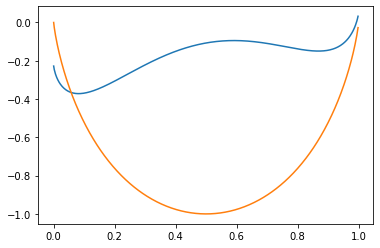

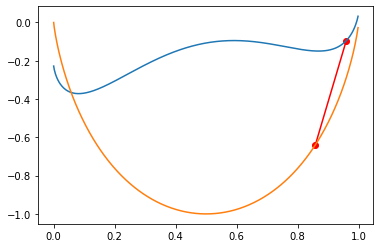

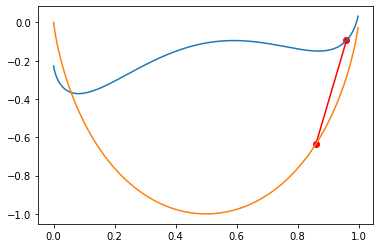

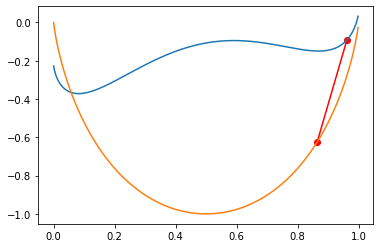

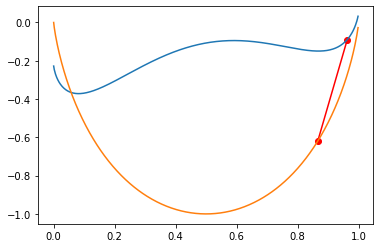

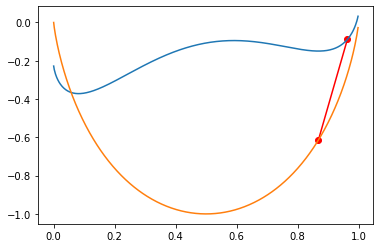

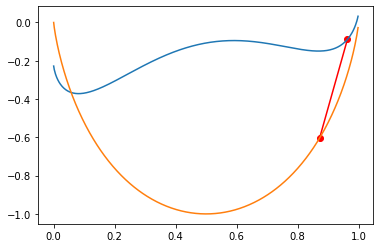

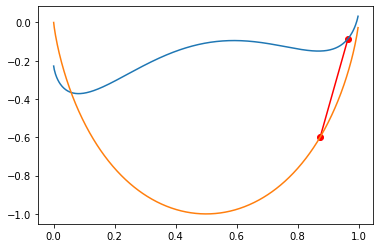

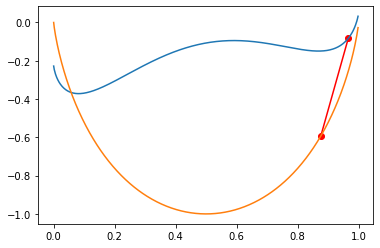

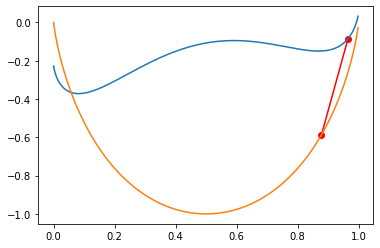

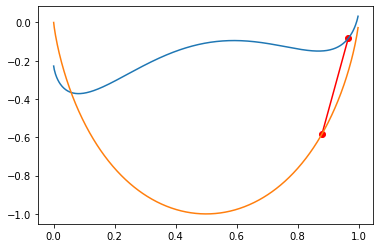

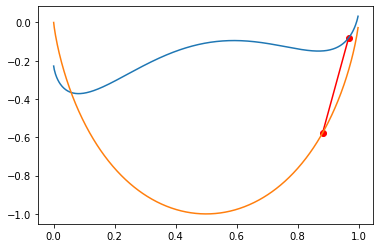

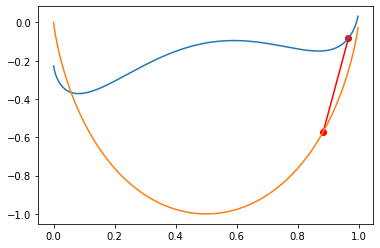

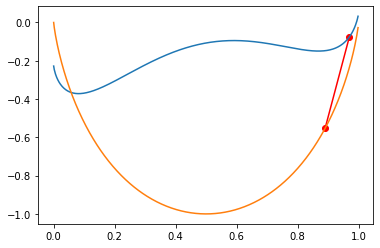

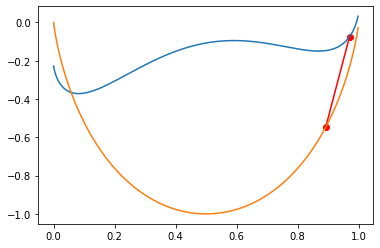

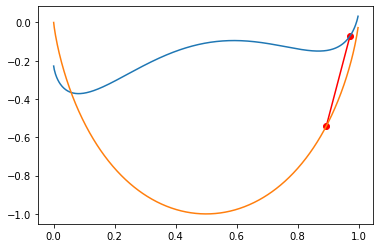

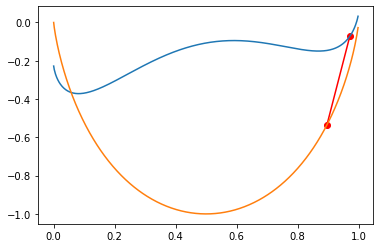

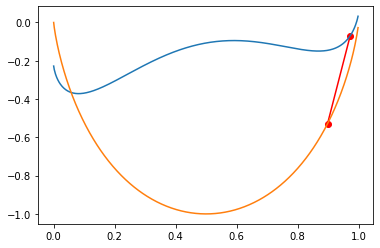

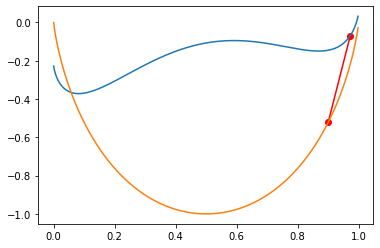

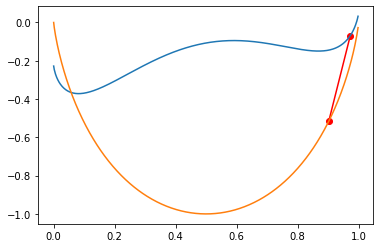

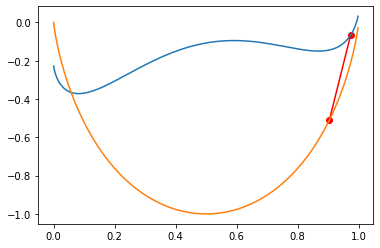

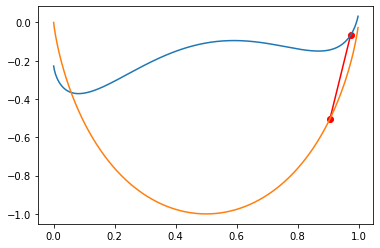

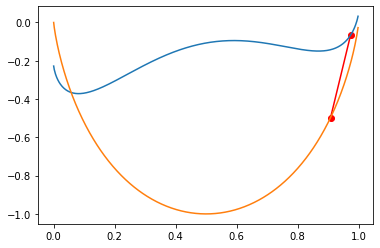

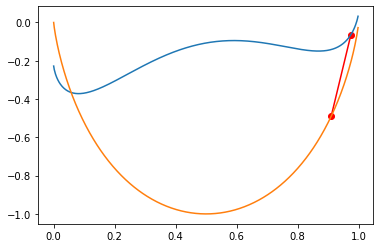

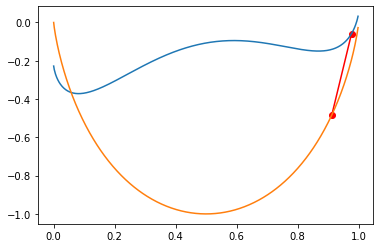

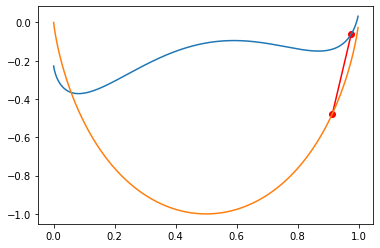

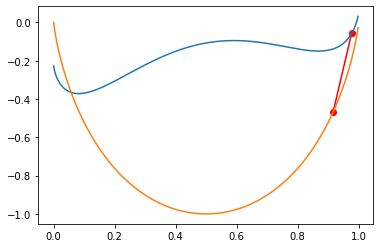

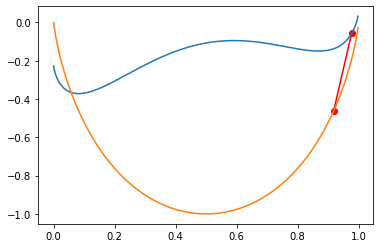

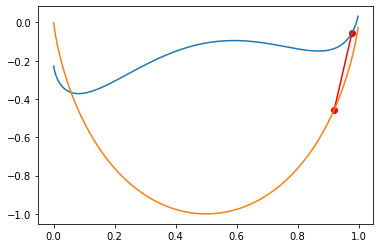

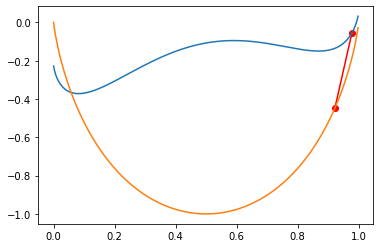

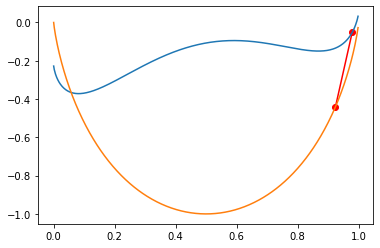

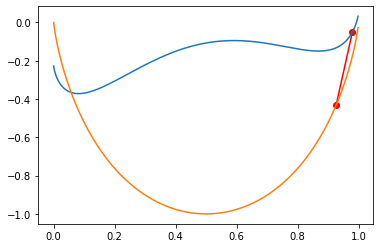

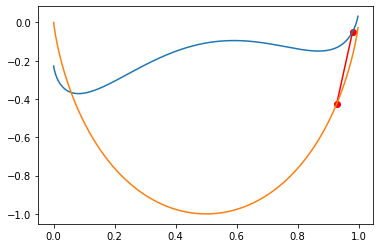

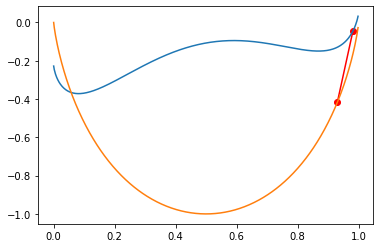

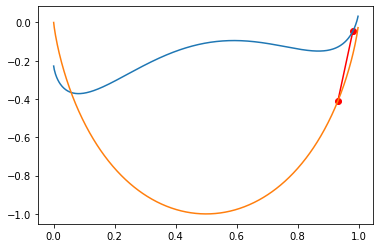

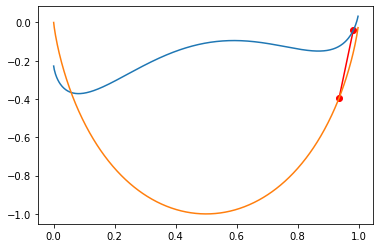

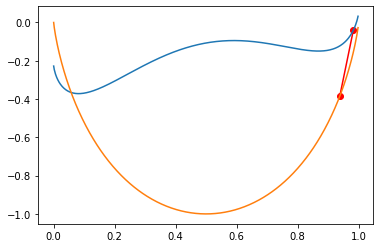

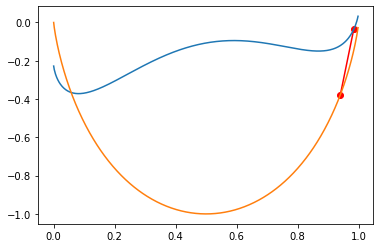

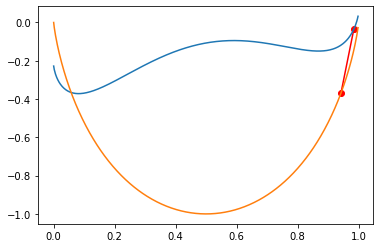

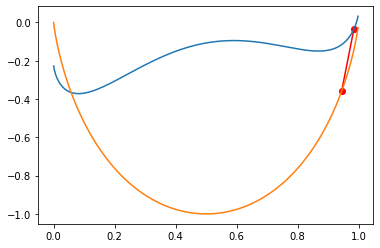

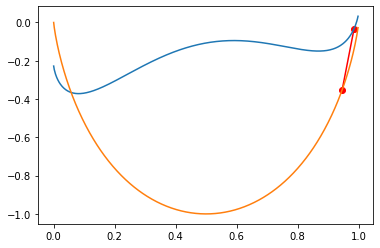

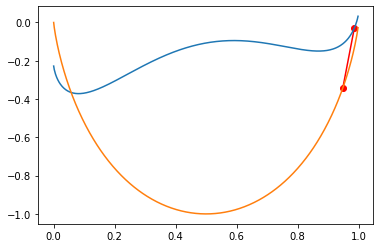

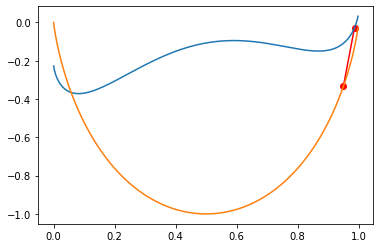

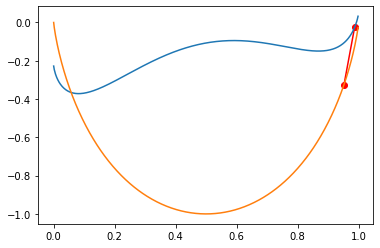

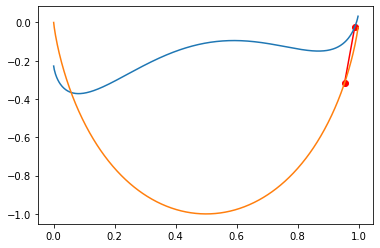

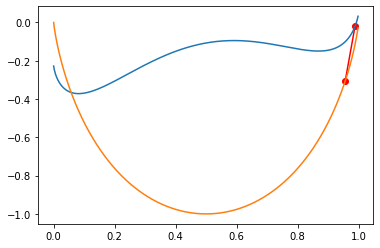

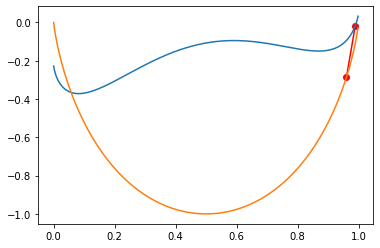

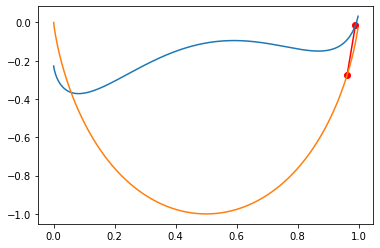

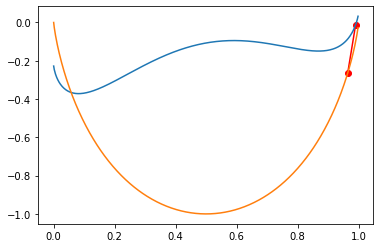

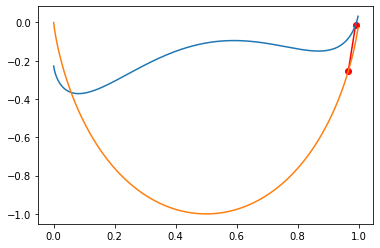

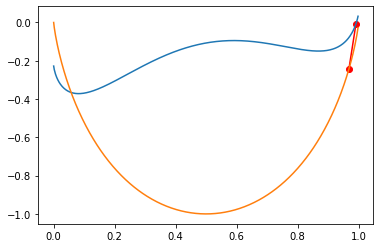

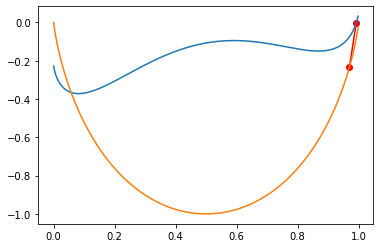

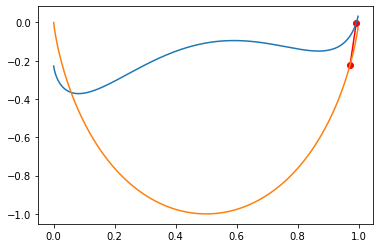

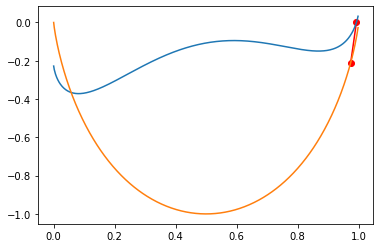

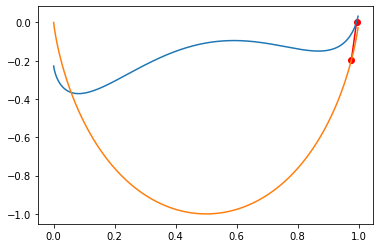

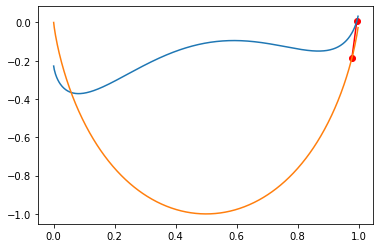

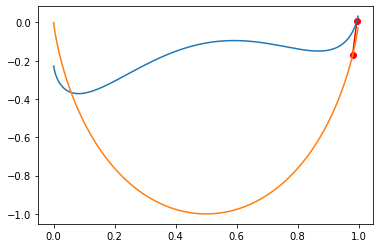

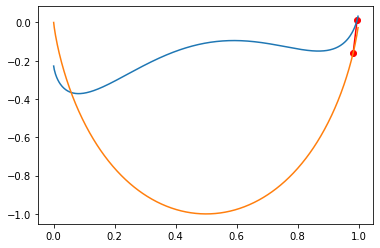

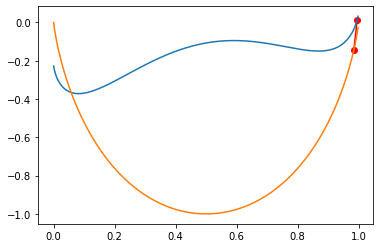

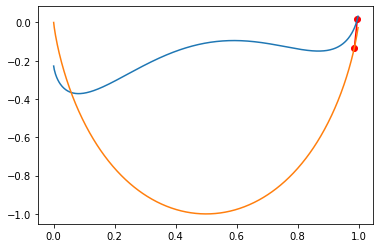

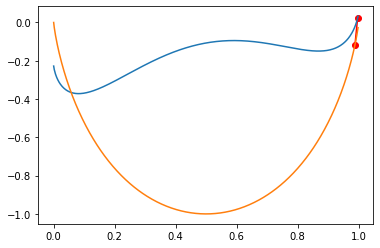

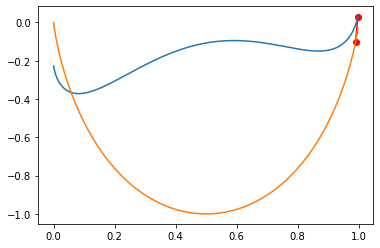

In [364]:
plt.plot(x, f)
plt.plot(x, g)
plt.show()
x_f = out[i_w]
x_g = x[i_w]
y_f = fpd.base_function(**d[1][0], x=x_f)/scale
y_g = fpd.base_function(**d[1][1], x=x_g)/scale

for o, xx, yy, yy_ in zip(x_f.detach(), x_g, y_f.detach(), y_g):
    plt.plot([o, xx], [yy, yy_], 'ro-')
    plt.plot(x, f)
    plt.plot(x, g)
    plt.show()
#plt.show()

In [120]:
print(eq(x_f, d[1][0]) - eq(x_g, d[1][1]))
print(dd(x_f, x_g))

tensor([ 9.7903e-02,  9.5197e-02,  9.2567e-02,  8.9973e-02,  8.7403e-02,
         8.4900e-02,  8.2438e-02,  8.0053e-02,  7.7709e-02,  7.5415e-02,
         7.4002e-02,  7.0982e-02,  6.8856e-02,  6.6764e-02,  6.4805e-02,
         6.2841e-02,  6.0932e-02,  5.9716e-02,  5.7244e-02,  5.5531e-02,
         5.3774e-02,  5.2057e-02,  5.0387e-02,  4.8938e-02,  4.7406e-02,
         4.5974e-02,  4.4566e-02,  4.3083e-02,  4.1753e-02,  4.0423e-02,
         3.8879e-02,  3.7979e-02,  3.6686e-02,  3.5460e-02,  3.4312e-02,
         3.3186e-02,  3.1846e-02,  3.0721e-02,  2.9645e-02,  2.7865e-02,
         2.6962e-02,  2.6449e-02,  2.4625e-02,  2.3616e-02,  2.2786e-02,
         2.2571e-02,  2.1612e-02,  1.6453e-02,  1.9658e-02,  1.8691e-02,
         1.7766e-02,  1.3134e-02,  1.2349e-02,  1.1621e-02,  1.0803e-02,
         1.0610e-02,  9.6661e-03,  8.2810e-03,  7.4504e-03,  6.6211e-03,
         5.9094e-03,  5.1915e-03,  4.3787e-03,  3.6414e-03,  3.0184e-03,
         2.3961e-03,  1.7293e-03,  9.1881e-04,  1.8

In [121]:
print((y_g - y_f)/(x_g - x_f))
print(fpd.first_derivative(**d[1][0],x=x_f)/scale)
print(((y_g - y_f)/(x_g - x_f) - fpd.first_derivative(**d[1][0],x=x_f)/scale))

tensor([ 1.3654,  1.3600,  1.3538,  1.3474,  1.3410,  1.3341,  1.3270,  1.3194,
         1.3116,  1.3037,  1.2880,  1.2873,  1.2788,  1.2703,  1.2610,  1.2521,
         1.2430,  1.2292,  1.2249,  1.2154,  1.2064,  1.1975,  1.1885,  1.1784,
         1.1691,  1.1595,  1.1500,  1.1412,  1.1318,  1.1227,  1.1150,  1.1040,
         1.0955,  1.0868,  1.0779,  1.0692,  1.0618,  1.0536,  1.0453,  1.0406,
         1.0320,  1.0218,  1.0179,  1.0104,  1.0024,  0.9921,  0.9852,  0.9953,
         0.9724,  0.9663,  0.9603,  0.9679,  0.9616,  0.9554,  0.9497,  0.9424,
         0.9379,  0.9349,  0.9306,  0.9266,  0.9227,  0.9192,  0.9164,  0.9139,
         0.9117,  0.9101,  0.9092,  0.9092,  0.9099,  0.9112,  0.9139,  0.9176,
         0.9227,  0.9297,  0.9291,  0.9359,  0.9639,  0.9827,  1.0074,  1.0381,
         1.0792,  1.1315,  1.1996,  1.2999,  1.4403,  1.6636,  2.0690,  3.0200,
         6.9374, -9.8293, -2.2860, -1.1011, -0.6224, -0.3641, -0.2158, -0.1097,
        -0.0350,  0.0198,  0.0625,  0.09